In [1]:
%pip install lightgbm==3.3.5

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import train_test_split

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor 

from IPython.display import display 

In [3]:
train_root_path = '../Kaggle - Santander Value Prediction Challenge/train/train.csv'
test_root_path = '../Kaggle - Santander Value Prediction Challenge/test/test.csv'

train_df = pd.read_csv(train_root_path)

test_df = pd.read_csv(test_root_path)

train_df.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [4]:
test_df.head()

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00056d8eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
print(f"Shape of train_df: {train_df.shape}")
print(f"Shape of test_df: {test_df.shape}")

Shape of train_df: (4459, 4993)
Shape of test_df: (49342, 4992)


There are 4459 rows in the train data set and 49342 rows in the test data set. WE also have 4993 columns in total including the target and id column.
- Test set is almost 10x the train set
- In the train dataset, the number of columns is more than the number of rows. Our dataset is weider than it is tall. We will need to be careful with feature engineering.
- We hgave an anonymized "ID" feature together with a numerical "Target" variable. The typical values of this target seem to be relatively high
- The remaining 4991 features are completely anonymous and appear to be primarily in integer or double format

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49342 entries, 0 to 49341
Columns: 4992 entries, ID to 9fc776466
dtypes: float64(4991), object(1)
memory usage: 1.8+ GB


# Exploratory Data Analysis

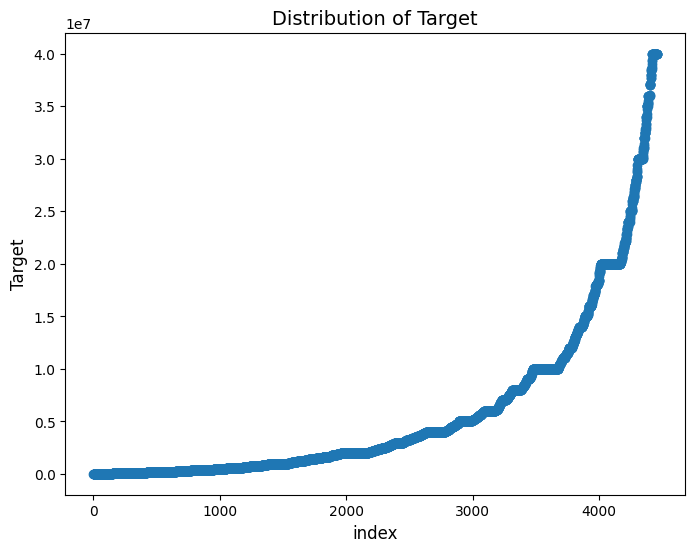

In [8]:
plt.figure(figsize=(8,6))

plt.scatter(range(train_df.shape[0]), np.sort(train_df['target'].values))

plt.xlabel('index', fontsize=12)
plt.ylabel('Target', fontsize=12)
plt.title('Distribution of Target', fontsize=14)
plt.show()

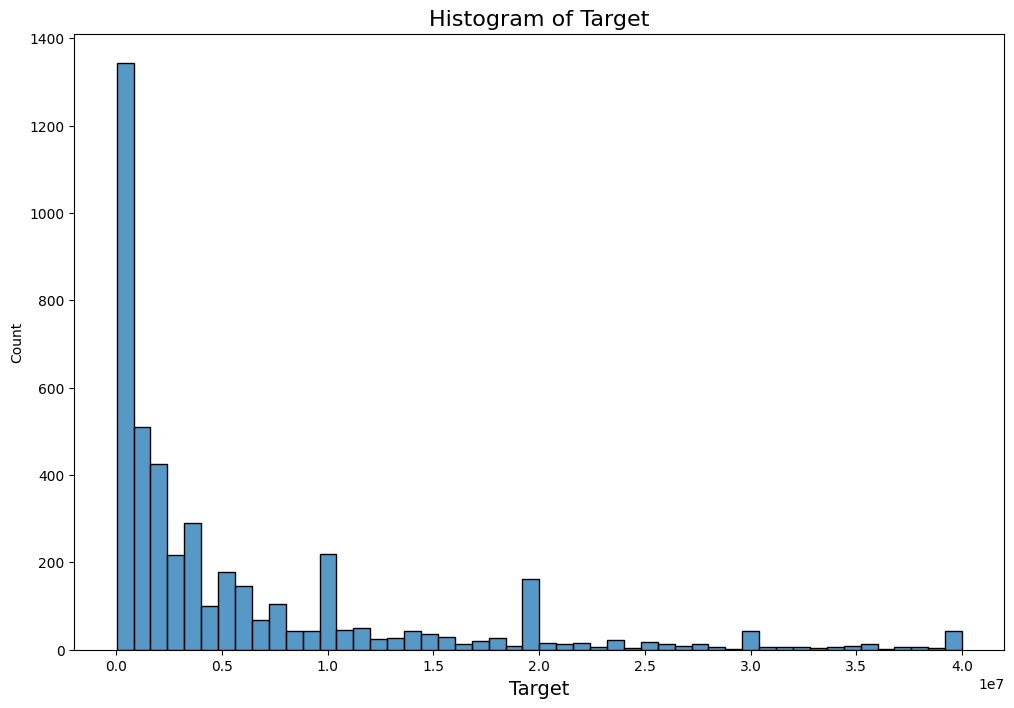

In [9]:
plt.figure(figsize=(12,8))

sns.histplot(train_df['target'].values, bins=50, kde=False)

plt.xlabel('Target', fontsize=14)
plt.title('Histogram of Target', fontsize=16)
plt.show()

<Figure size 1200x800 with 0 Axes>

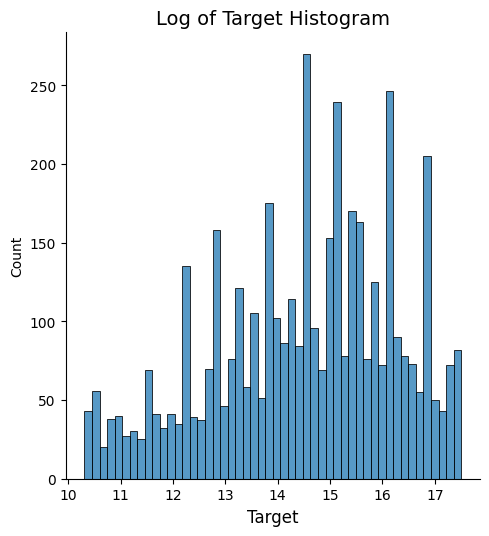

In [10]:
plt.figure(figsize=(12,8))

sns.displot(np.log1p(train_df['target'].values), bins=50, kde=False)  # Take the natural log of the absolute values of target and then plot histogram

plt.xlabel('Target', fontsize=12)
plt.title('Log of Target Histogram', fontsize=14)
plt.show()

In [11]:
check_NaN = str(train_df.columns[train_df.isnull().sum() != 0].size)  # To count the NaN values under the entire DataFrame 

print(f"All features in train data with NaN values = {check_NaN}")

All features in train data with NaN values = 0


If a feature has low variance, then it has a very low contribution to prediction. However, in boosting models these issues are accounted for. So let's remove variables which are constant, with a variance of zero

In [12]:
const_columns_to_remove = []

for col in train_df.columns:
    if col != 'ID' and col != 'target':
        if train_df[col].std() == 0:  # Only checking for standard deviation as exactly 0
            const_columns_to_remove.append(col)

# Now remove the array of const columns from the data
train_df.drop(const_columns_to_remove, axis=1, inplace=True)

test_df.drop(const_columns_to_remove, axis=1, inplace=True)

no_of_col = len(const_columns_to_remove)
print(f"The following number of constant columns have been removed: {no_of_col}")

# Print to see the reduction of columns
print(f"train_df rows and columns after removing constant columns: {train_df.shape}")

The following number of constant columns have been removed: 256
train_df rows and columns after removing constant columns: (4459, 4737)


# Remove duplicate columns 

In [13]:
train_df = train_df.loc[:, ~train_df.columns.duplicated()]

print(f"Train data set rows and columns after removing duplicate columns: {train_df.shape}")

Train data set rows and columns after removing duplicate columns: (4459, 4737)


In [14]:
def drop_sparse_from_train_test(train, test):
    column_list_to_drop_data_from = [x for x in train.columns if not x in ['ID', 'target']]  # Excluding ID and target

    for f in column_list_to_drop_data_from:
        if len(np.unique(train[f])) < 2:  # Removing those columns where the unique values of these columns are less than 2, indication that it's sparse data
            train.drop(f, axis=1, inplace=True)
            test.drop(f, axis=1, inplace=True)
    return train, test

train_df, test_df = drop_sparse_from_train_test(train_df, test_df)

# Split data into Train and Test for Model Training

In [15]:
x_train = train_df.drop(['ID', 'target'], axis=1)

y_train = np.log1p(train_df['target'].values)

x_test_original = test_df.drop('ID', axis=1)

x_train_split, x_validation, y_train_split, y_validation = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [16]:
print(f"x_train_split.shape: {x_train_split.shape}")
print(f"x_validation.shape: {x_validation.shape}")
print(f"y_train_split.shape: {y_train_split.shape}")
print(f"y_validation.shape: {y_validation.shape}")

x_train_split.shape: (3567, 4735)
x_validation.shape: (892, 4735)
y_train_split.shape: (3567,)
y_validation.shape: (892,)


# Deploy Models

## LightGBM Model:
- It is a gradient boosting model that makes use of tree based learning algorithms and is considered to be a fast processing algorithm
- While other Gradient Boosting algorithms trees grow horizontally, in LightGBM the trees grow vertically, meaning it grows leaf-wise while the other algorithms grow level-wise
- LightGBM  chooses the leaf with large loss to grow and it can lower down more loss than a level wise algorithm when growing in the same leaf

In [17]:
def light_gbm_model_run(train_x, train_y, validation_x, validation_y, test_x):
    """
    Run the LightGBM model for regression.

    Args:
        train_x (numpy.ndarray): Training input features.
        train_y (numpy.ndarray): Training target values.
        validation_x (numpy.ndarray): Validation input features.
        validation_y (numpy.ndarray): Validation target values.
        test_x (numpy.ndarray): Test input features.

    Returns:
        numpy.ndarray: Predicted target values for the test set.
        lightgbm.Booster: Trained LightGBM model.
        dict: Evaluation results of the LightGBM model.

    """
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 100,
        "learning_rate" : 0.001,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    
    # Given its a regression case, I am using the RMSE as the metric.

    lgbm_train = lgb.Dataset(train_x, label=train_y)
    
    lg_validation = lgb.Dataset(validation_x, label=validation_y)
    
    evals_result_lgbm = {}

    model_light_gbm = lgb.train(params, lgbm_train, 5000,
                      valid_sets=[lgbm_train, lg_validation],
                      early_stopping_rounds=100,
                      verbose_eval=150,
                      evals_result=evals_result_lgbm )
    
    pred_test_light_gbm = np.expm1(model_light_gbm.predict(test_x, num_iteration=model_light_gbm.best_iteration ))

    return pred_test_light_gbm, model_light_gbm, evals_result_lgbm

In [18]:
# Training and output of LightGBM Model
predicted_y_test_org_light_gbm, model_lgbm, evals_result_lgbm = light_gbm_model_run(x_train_split, y_train_split, x_validation, y_validation, x_test_original)

c:\Users\gabri\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\gabri\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\gabri\anaconda3\envs\pda-ie\Lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warn

[LightGBM] [Warning] Unknown parameter: bagging_frequency
Training until validation scores don't improve for 100 rounds
[150]	training's rmse: 1.66447	valid_1's rmse: 1.63998
[300]	training's rmse: 1.57647	valid_1's rmse: 1.59273
[450]	training's rmse: 1.49838	valid_1's rmse: 1.55444
[600]	training's rmse: 1.42899	valid_1's rmse: 1.5229
[750]	training's rmse: 1.36605	valid_1's rmse: 1.49779
[900]	training's rmse: 1.30903	valid_1's rmse: 1.47722
[1050]	training's rmse: 1.25715	valid_1's rmse: 1.46109
[1200]	training's rmse: 1.20994	valid_1's rmse: 1.44797
[1350]	training's rmse: 1.16675	valid_1's rmse: 1.43745
[1500]	training's rmse: 1.12708	valid_1's rmse: 1.42923
[1650]	training's rmse: 1.09046	valid_1's rmse: 1.42251
[1800]	training's rmse: 1.05679	valid_1's rmse: 1.41778
[1950]	training's rmse: 1.02548	valid_1's rmse: 1.41419
[2100]	training's rmse: 0.995928	valid_1's rmse: 1.4113
[2250]	training's rmse: 0.96824	valid_1's rmse: 1.40915
[2400]	training's rmse: 0.941909	valid_1's rmse

## XGBoost Model Training


XGBoost uses pre-sorted algorithim and histogram-based algorithm for computing the best split.

XGBoost adds built-in regularization to achieve accuracy gains beyond gradient boosting. The regularized parameters penalize complexity and smooth out the final weights to prevent overfitting. XGBoost is a regularized version of gradient boosting.

In [19]:
def xgb_model_run(train_x, train_y, validation_x, validation_y, test_x):
    """
    Run the XGBoost model for regression.

    Args:
        train_x (numpy.ndarray): Training input features.
        train_y (numpy.ndarray): Training target values.
        validation_x (numpy.ndarray): Validation input features.
        validation_y (numpy.ndarray): Validation target values.
        test_x (numpy.ndarray): Test input features.

    Returns:
        numpy.ndarray: Predicted target values for the test set.
        xgboost.Booster: Trained XGBoost model.

    """
    params = {
        'objective' : 'reg:squarederror',
        'eval_metric' : 'rmse',
        'eta' : 0.001,
        'max_depth' : 10,
        'subsample' : 0.6,
        'colsample_bytree' : 0.6,
        'alpha' : 0.001,
        'random_state' : 42
    }

    training_data = xgb.DMatrix(train_x, train_y)  # Using DMatrix since its more optimized in memory and training speed
    validation_data = xgb.DMatrix(validation_x, validation_y)

    watchlist = [(training_data, 'train'), (validation_data, 'valid')]  # Allows us to monitor the evaluation result on all data in the list

    model_xgb = xgb.train(params, training_data, 50, watchlist, maximize=False, early_stopping_rounds=100, verbose_eval=100)

    data_test = xgb.DMatrix(test_x)
    predict_test_xgb = np.expm1(model_xgb.predict(data_test, ntree_limit=model_xgb.best_ntree_limit))

    return predict_test_xgb, model_xgb

In [20]:
# Training XGB

predicted_y_test_org_xgbm, model_xgb = xgb_model_run(x_train_split, y_train_split, x_validation, y_validation, x_test_original)

[0]	train-rmse:14.08766	valid-rmse:14.07680


c:\Users\gabri\anaconda3\envs\pda-ie\Lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[49]	train-rmse:13.42473	valid-rmse:13.41323


c:\Users\gabri\anaconda3\envs\pda-ie\Lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


## CatBoost Model Training

CatBoost can be used to solve both classification and regression challenges. CatBoost is better at handling over-fitting. CatBoost grows a balanced tree.

In [21]:
model_catboost = CatBoostRegressor(iterations = 500,
                                   learning_rate=0.01,
                                   depth=10,
                                   eval_metric='RMSE',
                                   random_seed=42,
                                   bagging_temperature=0.2,
                                   od_type='Iter',
                                   metric_period=50,
                                   od_wait=20
)

model_catboost.fit(x_train_split, y_train_split,
                   eval_set=(x_validation, y_validation),
                   use_best_model=True,
                   verbose=50
                   )

predicted_y_test_org_catboost = np.expm1(model_catboost.predict(x_test_original))

0:	learn: 1.7614936	test: 1.6943084	best: 1.6943084 (0)	total: 1.33s	remaining: 11m 6s
50:	learn: 1.6747126	test: 1.6330977	best: 1.6330977 (50)	total: 55.8s	remaining: 8m 11s
100:	learn: 1.6096948	test: 1.5902474	best: 1.5902474 (100)	total: 1m 46s	remaining: 7m 1s
150:	learn: 1.5572985	test: 1.5589053	best: 1.5589053 (150)	total: 2m 40s	remaining: 6m 11s
200:	learn: 1.5167332	test: 1.5382647	best: 1.5382647 (200)	total: 3m 35s	remaining: 5m 21s
250:	learn: 1.4827385	test: 1.5217760	best: 1.5217760 (250)	total: 4m 31s	remaining: 4m 28s
300:	learn: 1.4545436	test: 1.5093004	best: 1.5093004 (300)	total: 5m 27s	remaining: 3m 36s
350:	learn: 1.4296056	test: 1.4994080	best: 1.4994080 (350)	total: 6m 23s	remaining: 2m 42s
400:	learn: 1.4078157	test: 1.4916401	best: 1.4916401 (400)	total: 7m 19s	remaining: 1m 48s
450:	learn: 1.3911783	test: 1.4861881	best: 1.4861881 (450)	total: 8m 16s	remaining: 53.9s
499:	learn: 1.3751665	test: 1.4807567	best: 1.4807567 (499)	total: 9m 10s	remaining: 0us



### Creating Output file for submission

In [24]:
submission_final = pd.read_csv('../Kaggle - Santander Value Prediction Challenge/sample_submission/sample_submission.csv')

In [27]:
submission_lgb = pd.DataFrame()
submission_lgb['target'] = predicted_y_test_org_light_gbm

submission_xgb = pd.DataFrame()
submission_xgb['target'] = predicted_y_test_org_xgbm

submission_catboost = pd.DataFrame()
submission_catboost['target'] = predicted_y_test_org_catboost

submission_final['target'] = (submission_lgb['target'] * 0.5 + submission_xgb['target'] * 0.3 + submission_catboost['target'] * 0.2)

In [28]:
submission_final.head()

,ID,target
0,000137c73,1.028001e+06
1,00021489f,1.218372e+06
2,0004d7953,1.599856e+06
3,00056a333,3.082969e+06
4,00056d8eb,1.401132e+06


In [ ]:
submission_final.to_csv('submission_combined_lgb_xgb_catboost.csv', index=False)